# Experiments with combining spectra

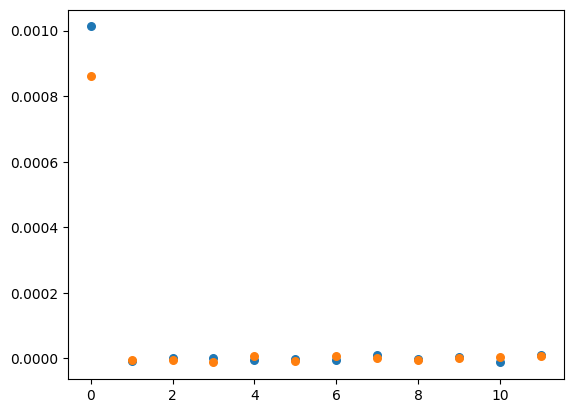

In [1]:
from frizzle import frizzle
import pickle

import numpy as np
with open("../foo.pkl", "rb") as fp:
    foo = pickle.load(fp)

# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.nan
    # sometimes standard practice can give nans when there are no data
    var[0] = np.nanmean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.nanmean(resids[lag:] * resids[:-lag])
    return lags, var

def get_XX_YY(xs, ys, y_ivars, bs, Delta_xs, x_min, x_max):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    YY_ivar = np.array([])
    for bb, yy, ivar, Dx in zip(bs, ys, y_ivars, Delta_xs):
        x_rest = (xs - Dx)[bb > 0.5]
        I = np.logical_and(x_rest > x_min, x_rest < x_max)
        YY = np.append(YY, yy[bb > 0.5][I])
        XX = np.append(XX, x_rest[I])
        YY_ivar = np.append(YY_ivar, ivar[bb > 0.5][I])
    return (XX, YY, YY_ivar)
def resample_spectrum(xs, ys, y_ivars, bs, Delta_xs, xstar, **kwargs):
    XX, YY, YY_ivar = get_XX_YY(xs, ys, y_ivars, bs, Delta_xs, *xstar[[0, -1]])
    return frizzle(xstar, XX, YY, YY_ivar, **kwargs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for i, items in foo.items():

    numerator = 0
    for (xs, ys, y_ivars, bs, Delta_xs, xstar, y_true) in items:
        
        y_star, Cinv_star, flags_star, _ = resample_spectrum(xs, ys, y_ivars, bs, Delta_xs, xstar, lsqr_kwds=dict(calc_var=False), censor_missing_regions=False)
        """
        y_star, *_ = frizzle(
            xstar,
            np.hstack([xs - delta_xs for delta_xs in Delta_xs]),
            np.hstack(ys),
            np.hstack(y_ivars),
            ~np.hstack(bs).astype(bool),
        )
        """
        #ystar_sp, _, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar)
        lags, covars = covariances(y_star - y_true)
        # sometimes standard practice will have nans at the edge
        #finite_sp = ystar_sp - y_true        
        numerator += covars
    
    ax.scatter(lags, numerator / len(items), label=i, s=30)


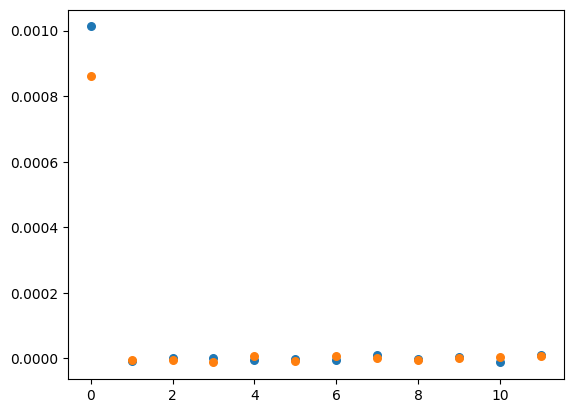

In [2]:
from frizzle import frizzle
import pickle

import numpy as np
with open("../foo.pkl", "rb") as fp:
    foo = pickle.load(fp)

# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.nan
    # sometimes standard practice can give nans when there are no data
    var[0] = np.nanmean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.nanmean(resids[lag:] * resids[:-lag])
    return lags, var

def get_XX_YY(xs, ys, y_ivars, bs, Delta_xs, x_min, x_max):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    YY_ivar = np.array([])
    for bb, yy, ivar, Dx in zip(bs, ys, y_ivars, Delta_xs):
        x_rest = (xs - Dx)[bb > 0.5]
        I = np.logical_and(x_rest > x_min, x_rest < x_max)
        YY = np.append(YY, yy[bb > 0.5][I])
        XX = np.append(XX, x_rest[I])
        YY_ivar = np.append(YY_ivar, ivar[bb > 0.5][I])
    return (XX, YY, YY_ivar)
def resample_spectrum(xs, ys, y_ivars, bs, Delta_xs, xstar, **kwargs):
    XX, YY, YY_ivar = get_XX_YY(xs, ys, y_ivars, bs, Delta_xs, *xstar[[0, -1]])
    return frizzle(xstar, XX, YY, YY_ivar, **kwargs)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for i, items in foo.items():

    numerator = 0
    for (xs, ys, y_ivars, bs, Delta_xs, xstar, y_true) in items:
        
        #y_star, Cinv_star, flags_star, _ = resample_spectrum(xs, ys, y_ivars, bs, Delta_xs, xstar)#lsqr_kwds=dict(calc_var=False), censor_missing_regions=False)
        all_xs = np.hstack([xs - delta_xs for delta_xs in Delta_xs])
        ys = np.hstack(ys)
        y_ivars = np.hstack(y_ivars)
        bs = np.hstack(bs).astype(bool)
        
        mask = (~bs) 
        before = np.sum(mask)
        #mask = mask * (all_xs > xstar[0]) * (all_xs < xstar[-1])
        
        y_star, *_ = frizzle(
            xstar,
            all_xs,
            ys,
            y_ivars,
            mask,
        )
        #ystar_sp, _, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar)
        lags, covars = covariances(y_star - y_true)
        # sometimes standard practice will have nans at the edge
        #finite_sp = ystar_sp - y_true        
        numerator += covars
    
    ax.scatter(lags, numerator / len(items), label=i, s=30)


<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_26406/3678860944.py:49: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


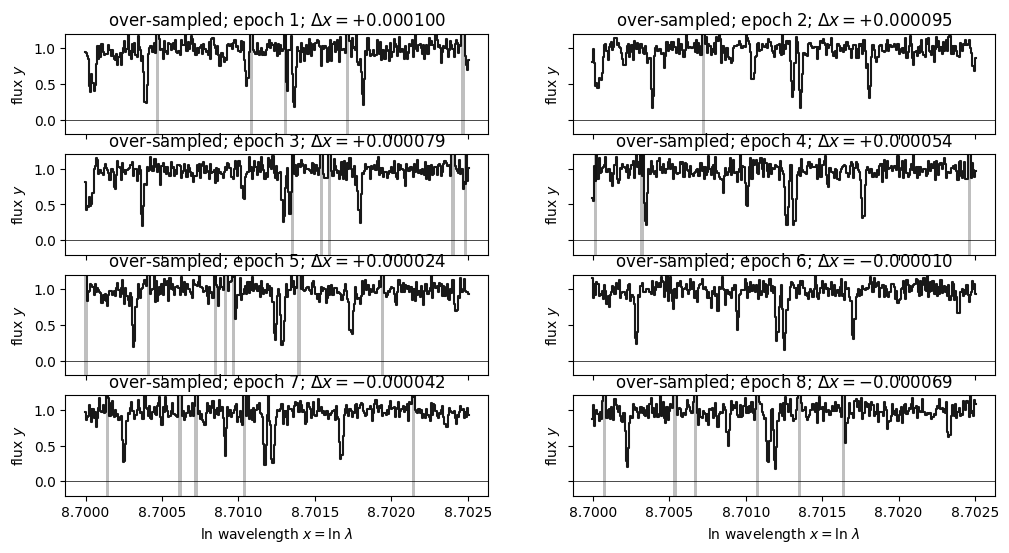

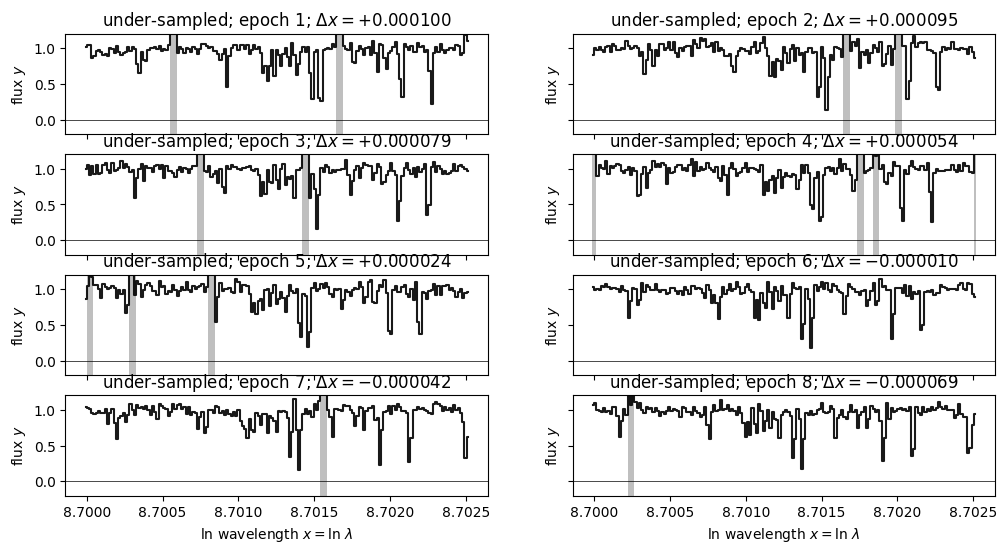

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from generate_data import make_one_dataset, true_spectrum
from frizzle import frizzle as jax_frizzle

R = 1.35e5

x_min = 8.7000
x_max = 8.7025

dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 1 * dxstar, x_max, dxstar)
if xstar.size % 2 == 0:
    xstar = xstar[:-1]  # make sure odd number of points for symmetry

dx_os = 1 / R
snr_os = 12

dx_us = 2 / R
snr_us = 18

P = np.round((x_max - x_min) * R).astype(int) # number of Fourier modes (ish)

dataset_kwds = dict(x_min=x_min, x_max=x_max)

# under-sampled case
xs_us, ys_us, ivars_us, bs_us, delta_xs_us, line_args_us = data_us = make_one_dataset(
    dx=dx_us, snr=snr_us, random_seed=17, **dataset_kwds
)

# over-sampled case
xs_os, ys_os, ivars_os, bs_os, delta_xs_os, line_args_os = data_os = make_one_dataset(
    dx=dx_os, snr=snr_os, random_seed=None, **dataset_kwds
)

# show the input data
for xs, ys, ivars, bs, Delta_xs, line_args, prefix, pfn \
        in [(*data_os, "over-sampled", "data1.pdf"),
            (*data_us, "under-sampled", "data2.pdf")]:
    
    N = len(ys)
    dx = np.diff(xs).mean()
    fig, axes = plt.subplots(N // 2, 2, sharex=True, sharey=True,
                         figsize=(12., 0.75 * N))
    for j,ax in enumerate(axes.flatten()):
        ax.axhline(0., color="k", lw=0.5)
        ax.step(xs, ys[j], color="k", where="mid", alpha=0.9)
        ax.set_title(prefix + "; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
        ax.set_ylabel(r"flux $y$")
        for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
            ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                            [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
    for j in range(2):
        axes[-1, j].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
    ylim = (-0.2, 1.2)
    plt.ylim(*ylim)
    plt.savefig(pfn)

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_26406/516776541.py:21: SyntaxWarning: invalid escape sequence '\D'
  axes[0].set_title("; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))


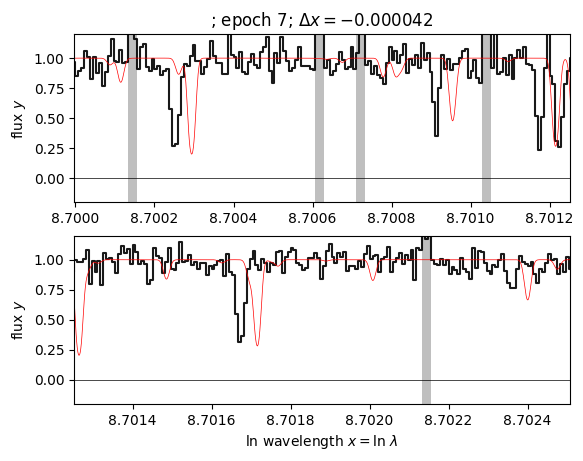

In [4]:

x_min, x_max = xs_os.min(), xs_os.max()
dx_os = np.diff(xs_os).mean()
# zoom in on one epoch and compare it to the true template.
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xs_os, ys_os[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0, *line_args_os), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(ys_os[j]))[bs_os[j] < 0.5]:
        ax.fill_between([xs_os[k] - 0.5 * dx_os, xs_os[k] + 0.5 * dx_os],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")

axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("; epoch {}; $\Delta x = {:+f}$".format(j + 1, Delta_xs[j]))
plt.savefig("datazoom.pdf")

In [5]:
def Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, kind="cubic"):
    #interpolate the data and the masks; deal with edges.
    # Note that we are being very conservative with the mask.
    N = len(ys)
    yprimes = np.zeros((N, len(xstar)))
    bprimes = np.zeros_like(yprimes).astype(int)
    ikwargs = {"kind": kind, "fill_value": "extrapolate"}
    for j in range(N):
        yprimes[j] = interp.interp1d(xs - Delta_xs[j], ys[j],
                                     **ikwargs)(xstar)
        bprimes[j] = (np.abs(interp.interp1d(xs - Delta_xs[j], bs[j],
                                     **ikwargs)(xstar) - 1.) < 0.03).astype(int)
        bprimes[j][xstar < (min(xs) - Delta_xs[j])] = 0
        bprimes[j][xstar > (max(xs) - Delta_xs[j])] = 0
    ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)
    return ystar, yprimes, bprimes

def design_matrix(xs, P, L=(x_max - x_min)):
    """
    Take in a set of x positions and return the Fourier design matrix.

    ## Bugs:
    - Needs comment header.
    
    ## Comments:
    - The code looks different from the paper because Python zero-indexes.
    - This could be replaced with something that makes use of finufft.
    """
    X = np.ones_like(xs).reshape(len(xs), 1)
    for j in range(1, P):
        if j % 2 == 0:
            X = np.concatenate((X, np.cos(np.pi * j * xs / L)[:, None]), axis=1)
        else:
            X = np.concatenate((X, np.sin(np.pi * (j + 1) * xs / L)[:, None]), axis=1)
    return X

def pack_matrices(xs, ys, bs, P):
    """
    Rearrange data into big matrices for `lstsq()`.

    ## Bugs:
    - Needs comment header.
    """
    XX = np.array([])
    YY = np.array([])
    #for bb, yy in zip(bs, ys):
    x_rest = xs[bs > 0.5]
    I = np.logical_and(x_rest > x_min, x_rest < x_max)
    YY = np.append(YY, ys[bs > 0.5][I])
    XX = np.append(XX, x_rest[I])
    return design_matrix(XX, P), YY



def hogg_frizzle(xstar, xs, ys, ivars, bs, n_modes=P, **kwargs):
    print("WARNING: Using Hogg's frizzle implementation. Who's that guy?!")
    #xs, ys, ivars, bs = map(np.hstack, (xs, ys, ivars, bs))
    X, Y = pack_matrices(xs, ys, (~bs).astype(int), n_modes)
    Xstar = design_matrix(xstar, n_modes)
    thetahat, foo, bar, whatevs = np.linalg.lstsq(X, Y, rcond=None)
    return (Xstar @ thetahat, None, None, None)


In [6]:
ystar_os, ivar_os, flags_os, meta_os = jax_frizzle(
    xstar,
    np.hstack([xs_os - delta_xs for delta_xs in delta_xs_os]),
    np.hstack(ys_os),
    np.hstack(ivars_os),
    ~np.hstack(bs_os).astype(bool)
)
ystar_us, ivar_us, flags_us, meta_us = jax_frizzle(
    xstar,
    np.hstack([xs_us - delta_xs for delta_xs in delta_xs_us]),
    np.hstack(ys_us),
    np.hstack(ivars_us),
    ~np.hstack(bs_us).astype(bool),
)


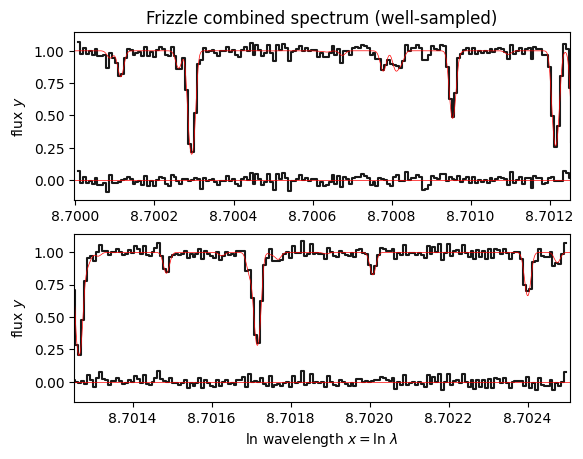

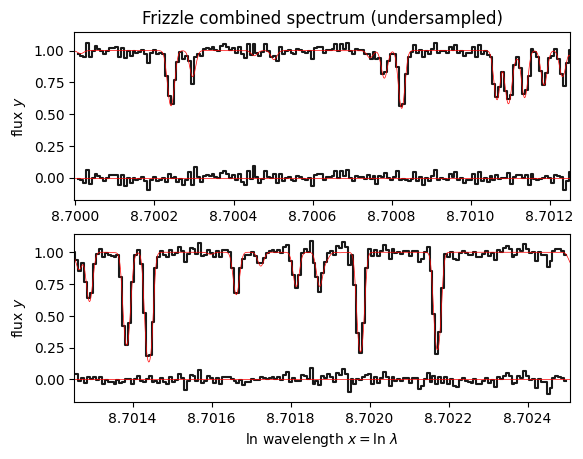

In [7]:
# compare the combined spectrum to the true template.
for ystar, line_args, name, pfn in [(ystar_os, line_args_os, "well-sampled", "forward1.pdf"),
                                    (ystar_us, line_args_us, "undersampled", "forward2.pdf")]:
    fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
    for ax in axes:
        ax.step(xstar, ystar, color="k", where="mid", alpha=0.9)
        ax.step(xstar, ystar - true_spectrum(xstar, 0., *line_args), color="k", where="mid", alpha=0.9)
        ax.set_ylabel(r"flux $y$")
        ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "r-", lw=0.5)
        ax.axhline(0., color="r", lw=0.5)
        ax.ticklabel_format(useOffset=False)
    axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
    axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
    #axes[0].set_ylim(*ylim)
    axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
    axes[0].set_title(f"Frizzle combined spectrum ({name})")
    plt.savefig(pfn)

In [8]:
# do the combination
ystar_sp_os, yprimes_os, bprimes_os = Standard_Practice_tm(xs_os, ys_os, bs_os, delta_xs_os, xstar)
ystar_sp_us, yprimes_us, bprimes_us = Standard_Practice_tm(xs_us, ys_us, bs_us, delta_xs_us, xstar)

Text(0.5, 1.0, 'over-sampled; epoch 7, interpolated to rest frame')

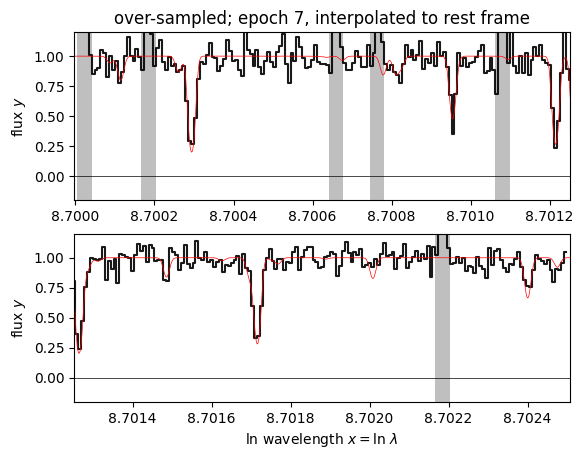

In [9]:
j = 6
fig, axes = plt.subplots(2, 1, sharex=False, sharey=True)
for ax in axes:
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xstar, yprimes_os[j], color="k", where="mid", alpha=0.9)
    ax.set_ylabel(r"flux $y$")
    ax.plot(finexs, true_spectrum(finexs, 0., *line_args_os), "r-", alpha=1.0, lw=0.5)
    ax.ticklabel_format(useOffset=False)
    for k in np.arange(len(yprimes_os[j]))[bprimes_os[j] < 0.5]:
        ax.fill_between([xstar[k] - 0.5 * dxstar, xstar[k] + 0.5 * dxstar],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
axes[0].set_xlim(x_min, 0.5 * (x_max + x_min))
axes[1].set_xlim(0.5 * (x_max + x_min), x_max)
axes[0].set_ylim(*ylim)
axes[1].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")
axes[0].set_title("over-sampled; epoch {}, interpolated to rest frame".format(j + 1))


In [10]:
# Estimate covariances from just one trial:
def covariances(resids):
    lags = np.arange(12)
    var = np.zeros(len(lags)) + np.nan
    # sometimes standard practice can give nans when there are no data
    var[0] = np.nanmean(resids * resids)
    for lag in lags[1:]:
        var[lag] = np.nanmean(resids[lag:] * resids[:-lag])
    return lags, var



def estimate_frizzle_lag(n_trials, xstar, frizzle, **dataset_kwds):
    numerator = 0
    for trial in range(n_trials):
        xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(**dataset_kwds)
        ystar, C_inv_star, *_ = frizzle(
            xstar,
            np.hstack([xs - delta_xs for delta_xs in Delta_xs]),
            np.hstack(ys),
            np.hstack(y_ivars),
            ~np.hstack(bs).astype(bool)
        )
        
        diff = (ystar - true_spectrum(xstar, 0., *line_args)) 
        lags, covars = covariances(diff)
        numerator += covars
    return (lags, numerator / n_trials)

def estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds, **dataset_kwds):
    if standard_practice_kwds is None:
        standard_practice_kwds = {}
    numerator = 0
    for trial in range(n_trials):
        xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(**dataset_kwds)
        ystar_sp, foo, bar = Standard_Practice_tm(xs, ys, bs, Delta_xs, xstar, **standard_practice_kwds)        
        lags, covars = covariances(ystar_sp - true_spectrum(xstar, 0., *line_args))
        numerator += covars
    return (lags, numerator / n_trials)



def plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials):
    frizzle_name = "Frizzle"
    standard_name = "Standard Practice"

    name1 = "over-sampled"
    name2 = "under-sampled"

    fig, ax = plt.subplots()
    ax.axhline(0., color="k", lw=0.5)
    ax.plot(lags, covars_frizzle_os, "ko", ms=5,
            label=frizzle_name + ", " + name1)
    ax.plot(lags, covars_sp_os, "ko", ms=5, mfc="none",
            label=standard_name + ", " + name1)
    if covars_frizzle_us is not None:
        ax.plot(lags, covars_frizzle_us, "ko", ms=10, alpha=0.5, mec="none",
                label=frizzle_name + ", " + name2)
    if covars_sp_us is not None:
        ax.plot(lags, covars_sp_us, "ko", ms=10, alpha=0.5, mfc="none",
                label=standard_name + ", " + name2)
    ax.legend()
    ax.set_xlabel("lag (in output pixels)")
    ax.set_ylabel("covariance (squared-flux units)")
    ax.set_title("covariances estimated from {} trials".format(n_trials))
    fig.tight_layout()
    return fig



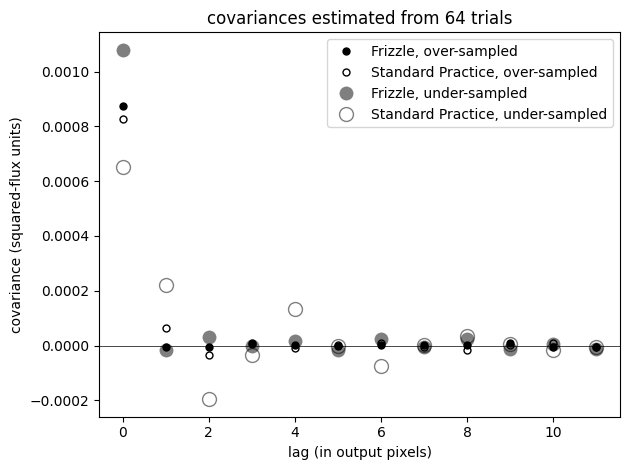

In [12]:
np.random.seed(42)

n_trials = 64
lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, hogg_frizzle, dx=dx_os, snr=snr_os, **dataset_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, hogg_frizzle, dx=dx_us, snr=snr_us, **dataset_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_os, snr=snr_os, **dataset_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_us, snr=snr_us, **dataset_kwds)
fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)

## Repeat baseline experiment with the new frizzle implementation

In [11]:
np.random.seed(42)

n_trials = 64
lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, dx=dx_os, snr=snr_os, badfrac=0, **dataset_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, dx=dx_us, snr=snr_us, badfrac=0, **dataset_kwds)

#lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_os, snr=snr_os, **dataset_kwds)
#lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, dx=dx_us, snr=snr_us, **dataset_kwds)


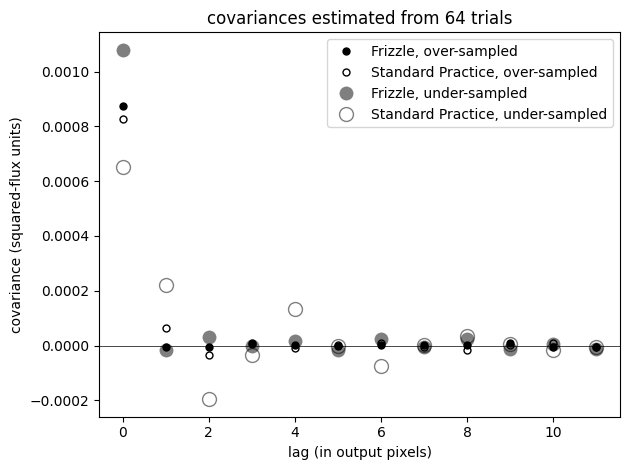

In [13]:
fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)

Satisfied that the results are largely the same, I will now use the newer implementation of frizzle for the rest of the notebook.
    
Remember that the results will not be exactly the same because the Hogg implementation does not use the pixel uncertainties.

# Experiment 1: Use Lorentzian line profiles


(-0.2, 1.2)

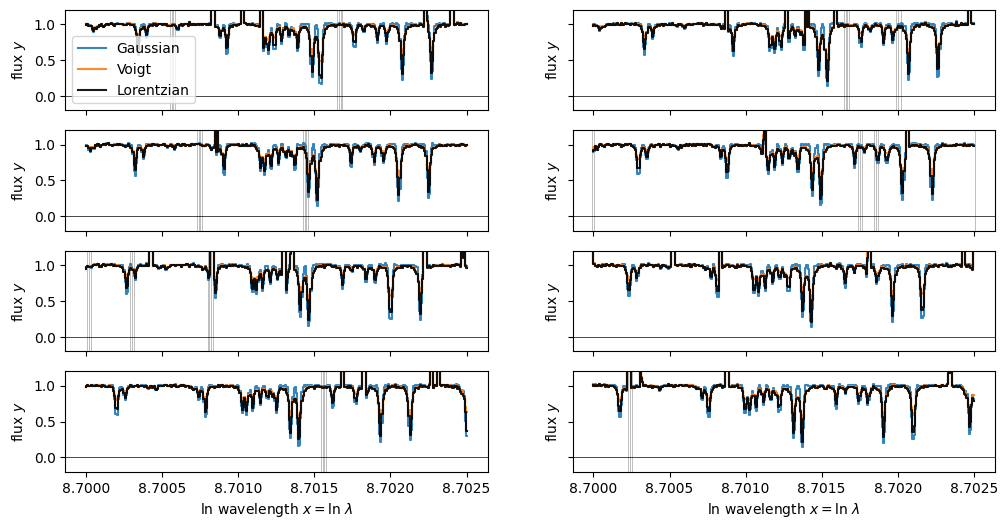

In [15]:

xs_l, ys_l, ivars_l, bs_l, Delta_xs_l, line_args_l = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="lorentzian", **dataset_kwds
)

xs_g, ys_g, ivars_g, bs_g, Delta_xs_g, line_args_g = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="gaussian", **dataset_kwds
)
xs_v, ys_v, ivars_v, bs_v, Delta_xs_v, line_args_v = make_one_dataset(
    dx=dx_os, snr=100, random_seed=17, profile_type="voigt", **dataset_kwds
)

N = len(ys_l)
dx = np.diff(xs_l).mean()
fig, axes = plt.subplots(N // 2, 2, sharex=True, sharey=True,
                        figsize=(12., 0.75 * N))
for j,ax in enumerate(axes.flatten()):
    ax.axhline(0., color="k", lw=0.5)
    ax.step(xs_l, ys_g[j], color="tab:blue", where="mid", alpha=0.9, label="Gaussian")    
    ax.step(xs_l, ys_v[j], color="tab:orange", where="mid", alpha=0.9, label="Voigt")
    ax.step(xs_l, ys_l[j], color="k", where="mid", alpha=0.9, label="Lorentzian")
    ax.set_ylabel(r"flux $y$")
    for k in np.arange(len(ys[j]))[bs[j] < 0.5]:
        ax.fill_between([xs[k] - 0.5 * dx, xs[k] + 0.5 * dx],
                        [-1., -1.], [2., 2.], color="k", alpha=0.25, ec="none")
for j in range(2):
    axes[-1, j].set_xlabel(r"ln wavelength $x=\ln\,\lambda$")

axes[0,0].legend()
ylim = (-0.2, 1.2)
plt.ylim(*ylim)


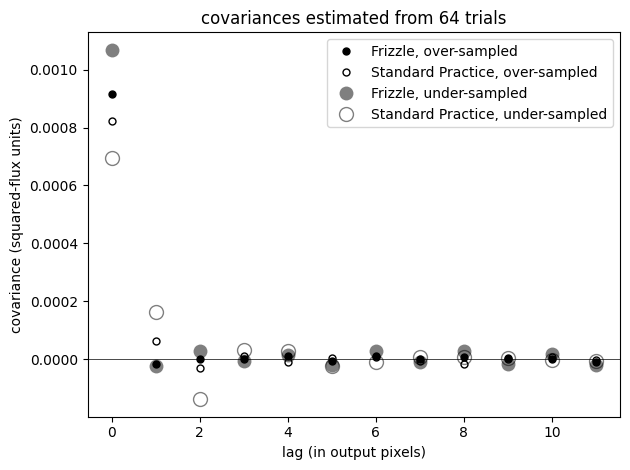

In [16]:
np.random.seed(42)

os_kwds = dict(dx=dx_os, N=8, snr=snr_os, **dataset_kwds)
us_kwds = dict(dx=dx_us, N=8, snr=snr_us, **dataset_kwds)

profile_type = "lorentzian"

n_trials = 64
lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)

# Experiment 2: Use voigt profiles

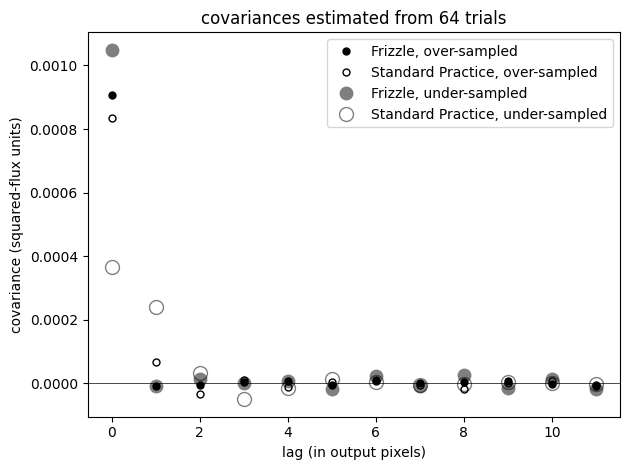

In [17]:
n_trials = 64
profile_type = "voigt"

np.random.seed(42)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


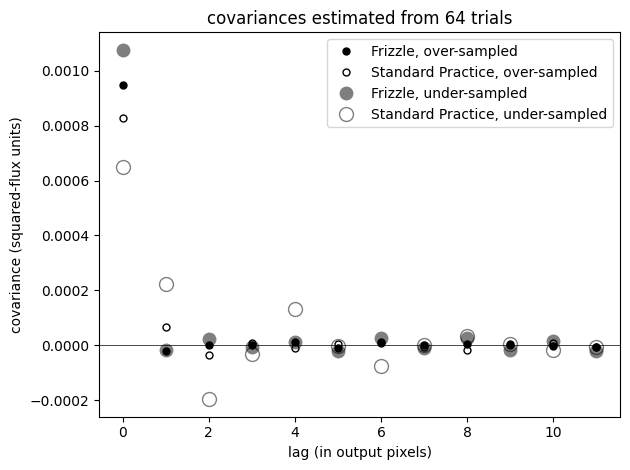

In [18]:
n_trials = 64
profile_type = "gaussian"

np.random.seed(42)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=None, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 3: Include linear interpolation as a Standard Practice comparison


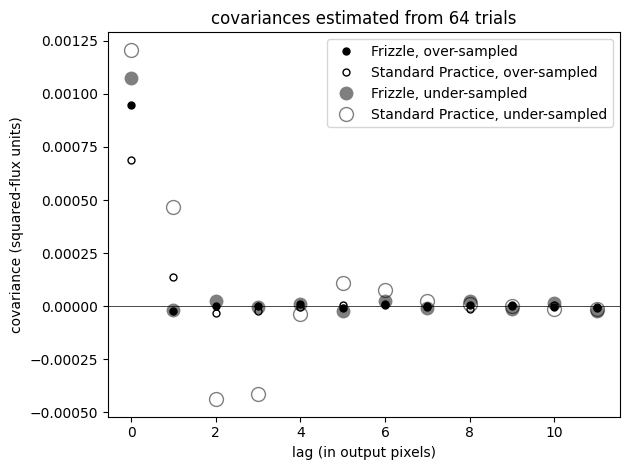

In [19]:
profile_type = "gaussian"
standard_practice_kwds = dict(kind="linear")
n_trials = 64

np.random.seed(42)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **os_kwds)
lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, profile_type=profile_type, **us_kwds)

lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, profile_type=profile_type, **os_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, profile_type=profile_type, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 4: Single epoch resampling, from more pixels to fewer.

3.7037037037279674e-06 [3.7037037e-06]
319 309


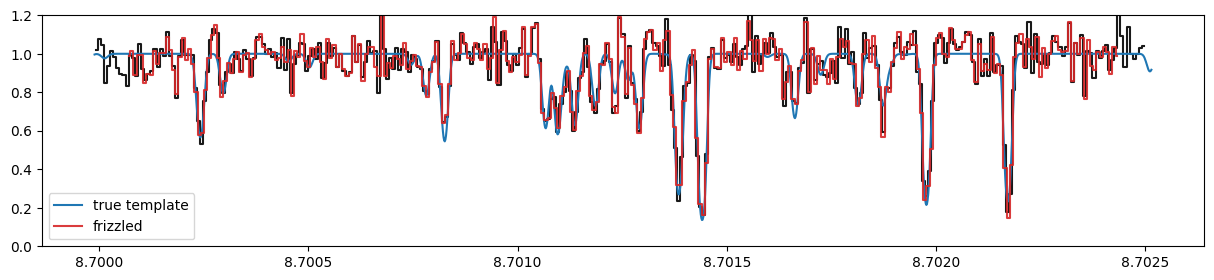

In [24]:
# oversampled
xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(
    dx=dx_os, 
    snr=snr_os, 
    N=1, 
    random_seed=17, 
    profile_type="gaussian", 
    Delta_xs=np.array([0.5 * dx_os]),
    badfrac=0,
    **dataset_kwds
)
print(dx_os * 0.5, Delta_xs)
xstar = np.linspace(xs[10], xs[-10], len(xs) - 30)
xi = np.hstack([xs - delta_xs for delta_xs in Delta_xs])
n_modes = int(np.sum(bs[0][(xstar[-1] > xi) * (xi > xstar[0])])) 
if n_modes % 2 == 0:
    n_modes -= 1

print(n_modes, len(xstar))
ystar, *_, meta = jax_frizzle(
    xstar, 
    xi,
    np.hstack(ys),
    np.hstack(y_ivars),
    ~np.hstack(bs).astype(bool),
    #n_modes=n_modes,
)

finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(xs - Delta_xs[0], ys[0], color="k", where="mid", alpha=0.9)
ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "tab:blue", label="true template")
ax.step(xstar, ystar, color="tab:red", where="mid", alpha=0.9, label="frizzled")
ax.set_ylim(0, 1.2)
ax.legend()

# Experiment 5: Single epoch resampling, going from P pixels to P different pixels.


# Experiment 6: Multi-epoch data with near zero delta x variations


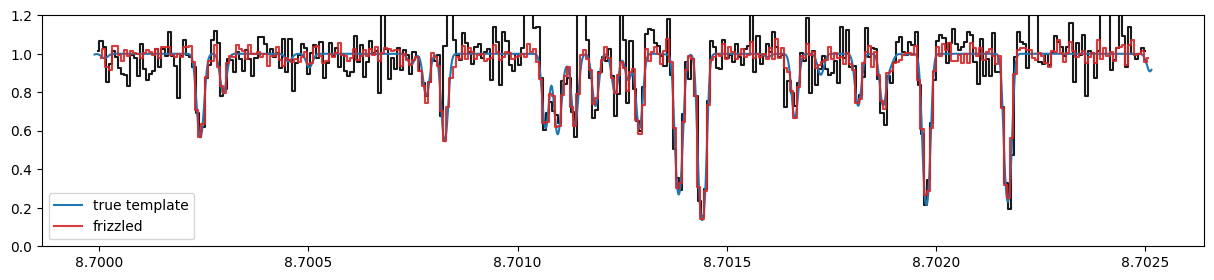

In [25]:
N = 8

dxstar = 1. / R # output pixel grid spacing
xstar = np.arange(x_min + 1 * dxstar, x_max, dxstar)
if xstar.size % 2 == 0:
    xstar = xstar[:-1]  # make sure odd number of points for symmetry

small = 1e-6
xs, ys, y_ivars, bs, Delta_xs, line_args = make_one_dataset(
    dx=dx_os, 
    snr=snr_os, 
    N=N, 
    random_seed=17, 
    profile_type="gaussian", 
    Delta_xs=np.random.uniform(low=-small, high=small, size=N),
    **dataset_kwds
)
ystar, *_, meta = jax_frizzle(
    xstar, 
    np.hstack([xs - dxs for dxs in Delta_xs]),
    np.hstack(ys),
    np.hstack(y_ivars),
    ~np.hstack(bs).astype(bool),
)

finexs = np.arange(x_min - 1. / R, x_max + 1. / R, 1. / (5. * R))

fig, ax = plt.subplots(figsize=(15, 3))
ax.step(xs - Delta_xs[0], ys[0], color="k", where="mid", alpha=0.9)
ax.plot(finexs, true_spectrum(finexs, 0., *line_args), "tab:blue", label="true template")
ax.step(xstar, ystar, color="tab:red", where="mid", alpha=0.9, label="frizzled")
ax.set_ylim(0, 1.2)
ax.legend()

/var/folders/r8/bk71hhjn6yzd4qpnmwrx9cjm0000gn/T/ipykernel_26406/1379805260.py:15: RuntimeWarning: invalid value encountered in divide
  ystar = np.sum(yprimes * bprimes, axis=0) / np.sum(bprimes, axis=0)


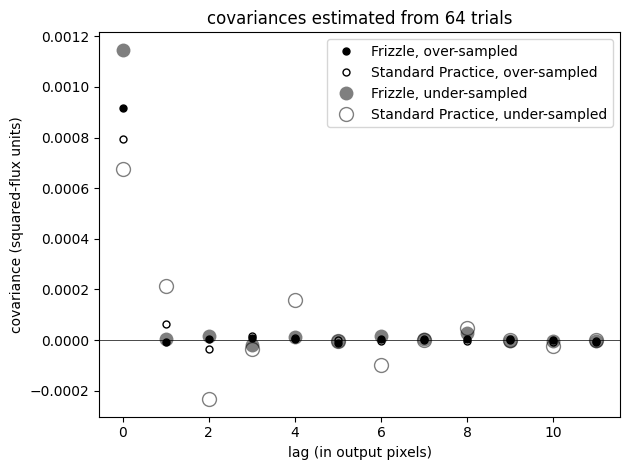

In [26]:
profile_type = "gaussian"
standard_practice_kwds = dict(kind="cubic")

N = 8

n_trials = 64

np.random.seed(42)
small = 1e-5

os_kwds = dict(dx=dx_os, N=N, snr=snr_os, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)
us_kwds = dict(dx=dx_us, N=N, snr=snr_us, Delta_xs=np.random.uniform(low=-small, high=+small, size=N), **dataset_kwds)

lags, covars_frizzle_os = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, **os_kwds)
lags, covars_sp_os = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **os_kwds)

lags, covars_frizzle_us = estimate_frizzle_lag(n_trials, xstar, jax_frizzle, **us_kwds)
lags, covars_sp_us = estimate_standard_practice_lag(n_trials, xstar, standard_practice_kwds=standard_practice_kwds, **us_kwds)

fig = plot_covariances(lags, covars_frizzle_os, covars_sp_os, covars_frizzle_us, covars_sp_us, n_trials)


# Experiment 7: Compute cost scaling